# Composite Indicator

In [1]:
#importing libraries
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo
import warnings
from typing import Literal
warnings.filterwarnings('ignore')

%load_ext extensions.skip

# defining a style
sns.set(style='darkgrid')
colors = ['#1a96d0', '#fe9c39', '#25ba31', '#EC5A77']

/home/gisliany/anaconda3/envs/master-research/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
# choose the spatial unit: neighborhood or hdu
spatial_unit = 'hdu'

spatial_area_label = 'hdu_id' if spatial_unit == 'hdu' else 'neighborhood'

## 1. Loading the data

This provided dataset is the one obtained after the data cleaning stage mentioned in the article *"A composite indicator of liveability based on sociodemographic and Uber quality service dimensions: a data-driven approach"*.

In [3]:
df = pd.read_csv("./data/uber_{}.csv".format(spatial_unit), index_col=0)

In [4]:
df[spatial_area_label] = df[spatial_area_label].astype(str)

### 1.1. Preparing the data

In [5]:
# adding new variables
if spatial_unit == 'neighborhood':
  df['car_crimes_rate'] = 100000*(df['car_theft'] + df['car_robbery'])/df['population']
  df['urban_services_ratio'] = 100000*(df['education_units'] + df['health_units'] + df['security_units'])/df['population']

In [6]:
numeric_cols = list(df.select_dtypes(['float64', 'int64']).columns)

# Selecting numeric columns and standardizing the variables
numerical_data = df[numeric_cols]
scaler = StandardScaler()
# data have to be standardized, once this is a requirement to run FA
numerical_data = scaler.fit_transform(numerical_data)

df_numerical = pd.DataFrame(numerical_data, columns = numeric_cols)
df_numerical.shape

(58, 15)

## 2. Composite Indicator of Liveability (CIL)

### 2.1. Factor Analysis (FA)

#### 2.1.1. Checking correlations


**CORRELATIONS**

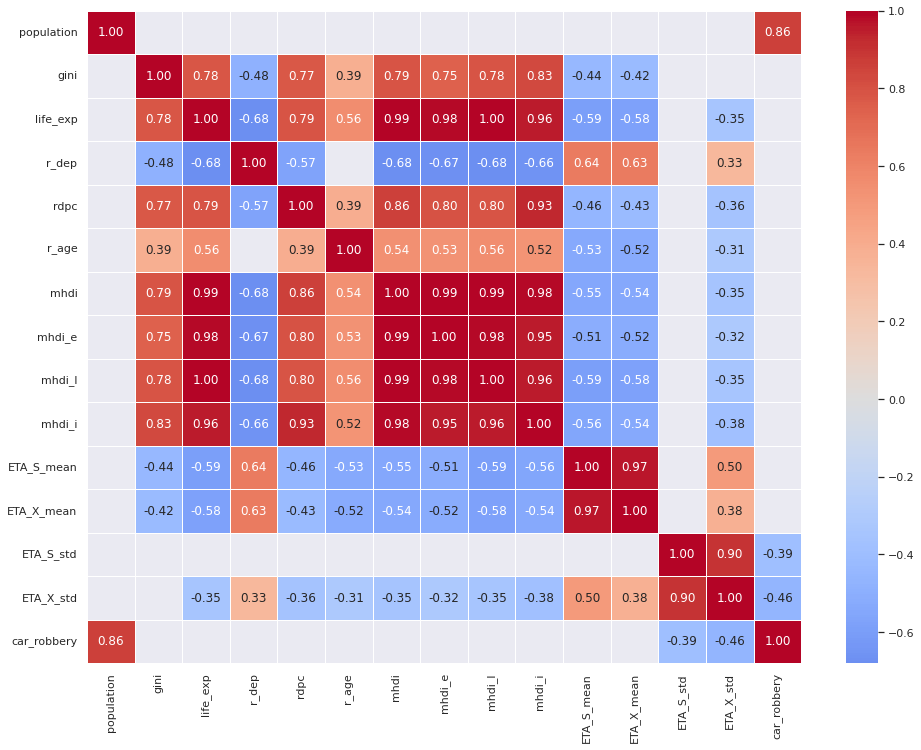

In [7]:
corr = df_numerical.corr()
fig, ax = plt.subplots(figsize=(16,12))

# Hiding the correlations that are smaller than 0.3
sns.heatmap(corr, mask = corr.abs() < 0.3, cmap="coolwarm", center=0, annot=True, fmt=".2f", linewidths=.5, ax=ax)
bottom, top = ax.get_ylim()

In [8]:
(corr.abs() < 0.3).sum().sum()/corr.shape[0]**2

0.3288888888888889

Initially, the Factor Analysis (FA) was undertaken considering neighborhood as unit of analysis. However, this dataset did not meet the suitability criteria for the FA implementation, mainly because its variables are mostly weakly correlated (about **57%** of the correlogram coefficients were less than 0.3 and more than **76%** were less than 0.5).  Consequently, it was not feasible to implement the indicator for this spatial aggregation level.

In the case of intra-neighborhood (HDU), three variables (population, car_robbery, ETA_S_std) with the highest amount of weak correlations had to be eliminated so that all the FA suitability criteria could be met.

In [9]:
# As the strong correlations were found only in the HDU dataset, we can skip the following steps for the neighborhood dataset
skip_cell = spatial_unit == 'neighborhood'

In [10]:
%%skip $skip_cell

df_numerical = df_numerical.drop(['population', 'car_robbery', 'ETA_S_std'], axis=1)

# checking the ratio of correlation values that are smaller than 0.3
corr = df_numerical.corr()
print((corr.abs() < 0.3).sum().sum()/corr.shape[0]**2)

0.027777777777777776


#### 2.1.2. suitability criteria

**STATISTICAL TESTS**

**Bartlett’s test** of sphericity checks whether or not the observed variables intercorrelate at all using the observed correlation matrix against the identity matrix. If the test found statistically insignificant, you should not employ factor analysis.

**Kaiser-Meyer-Olkin (KMO) test** measures the suitability of data for factor analysis. It determines the adequacy for each observed variable and for the complete model. KMO estimates the proportion of variance among all the observed variables and ranges between 0 and 1. In general, a KMO < 0.6 is considered inadequate.

In [11]:
def is_suitable_for_fa(df):
  chisquare, pvalue_bartlett = calculate_bartlett_sphericity(df)
  _, kmo_total = calculate_kmo(df)
  
  print('Check suitability')
  print('- Chi-square statistic is {:.4f}, with p-value {}'.format(chisquare, pvalue_bartlett))
  print('- Total KMO is {:.4f}'.format(kmo_total))

  # checks if Bartlett's test is significant (< 0.05) and the total KMO is at least 0.6 (>= 0.6).
  return pvalue_bartlett < 0.05 and kmo_total >= 0.6

#### 2.1.3. Factor Extraction using Principal Component Analysis (PCA) and factor rotation

In [12]:
def get_number_of_factors(df: pd.DataFrame):
  fa = FactorAnalyzer(n_factors=df.shape[1], method='principal', rotation=None)
  fa.fit(df)

  eigenvalues, _ = fa.get_eigenvalues()
  _, prop_variance, cum_variance = fa.get_factor_variance()
  n_factors = np.sum((eigenvalues > 1) & (prop_variance > 0.1))

  print('Number of factors: ', n_factors)
  print('- Proportion of variance explained by the {} factor(s): '.format(n_factors), prop_variance[:n_factors])
  print('- Proportion of cumulative variance of {} factor(s): '.format(n_factors), cum_variance[n_factors - 1])
  plot_factor_extraction(df, eigenvalues, prop_variance, cum_variance)

  return n_factors

def plot_eigenvalues(df, eigenvalues, ax):
  ax.scatter(range(1, df.shape[1]+1), eigenvalues)
  ax.plot(range(1, df.shape[1]+1), eigenvalues)
  ax.plot(range(1, df.shape[1]+1), [1] * df.shape[1], '--', linewidth=1.5, color="red")
  ax.set_xlabel('Factors')
  ax.set_ylabel('Eigenvalues')

def plot_explained_variance(prop_variance, ax):
  ax.bar(range(1, len(prop_variance) + 1), prop_variance)
  ax.set_xlabel('Number of components')
  ax.set_ylabel('Proportion of explained variance (%)')

def plot_cumulative_variance(cum_variance, ax):
  ax.plot(range(1, len(cum_variance) + 1), cum_variance)
  ax.scatter(range(1, len(cum_variance) + 1), cum_variance)
  ax.set_xlabel('Number of components')
  ax.set_ylabel('Proportion of cumulative variance (%)')

def plot_factor_extraction(df, eigenvalues, prop_variance, cum_variance, i = 1):
  fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18,4))

  plot_eigenvalues(df, eigenvalues, axs[0])
  plot_explained_variance(prop_variance, axs[1])
  plot_cumulative_variance(cum_variance, axs[2])
  
  plt.show()

In [13]:
FILTERS = Literal['communalities', 'loadings']

def get_removable_features(by: FILTERS, fa: FactorAnalyzer, features):
  if by == 'communalities':
    return get_removable_features_by_communalities(fa, features)
  elif by == 'loadings':
    return get_removable_features_by_loadings(fa, features)

def get_removable_features_by_communalities(fa: FactorAnalyzer, features, threshold = 0.5):
  communalities = fa.get_communalities()
  return list(features[communalities < threshold])

def get_removable_features_by_loadings(fa: FactorAnalyzer, features, threshold = 0.4):
  condition = (abs(fa.loadings_) > threshold).all(axis=1)
  return list(features[condition])

In [14]:
def perform_factor_analysis(df, i=1):
  print('ITERATION #{}'.format(i))

  if (is_suitable_for_fa(df)):
    n_factors = get_number_of_factors(df)

    fa = FactorAnalyzer(n_factors=n_factors, method='principal', rotation='varimax')
    fa.fit(df)

    cols_to_drop = get_removable_features('communalities', fa, df.columns) or \
      get_removable_features('loadings', fa, df.columns)
    if len(cols_to_drop) > 0:
      return perform_factor_analysis(df.drop(columns=cols_to_drop, axis=1), i + 1)
    print_factors(fa, df.columns, n_factors)
    return fa, df.columns, n_factors

def print_factors(fa, features, n_factors):
  cols = ['Factor ' + str(i + 1) for i in range(n_factors)]
  factors_df = pd.DataFrame(np.copy(fa.loadings_), columns=cols, index=features)
  print(factors_df)


ITERATION #1
Check suitability
- Chi-square statistic is 2082.2473, with p-value 0.0
- Total KMO is 0.7618
Number of factors:  2
- Proportion of variance explained by the 2 factor(s):  [0.67950291 0.12000813]
- Proportion of cumulative variance of 2 factor(s):  0.799511038111479


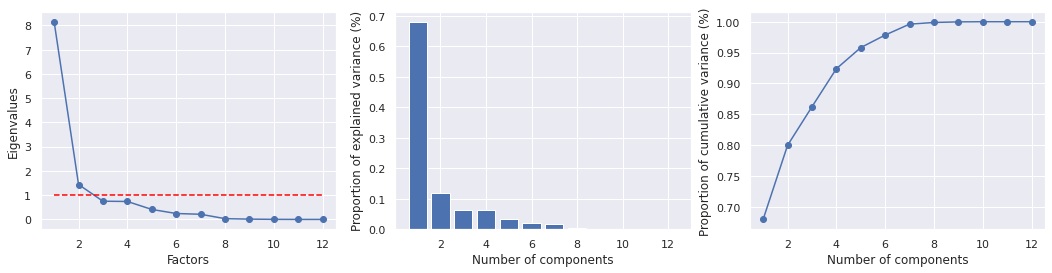

ITERATION #2
Check suitability
- Chi-square statistic is 2032.5848, with p-value 0.0
- Total KMO is 0.7581
Number of factors:  2
- Proportion of variance explained by the 2 factor(s):  [0.76326504 0.13017519]
- Proportion of cumulative variance of 2 factor(s):  0.8934402312773262


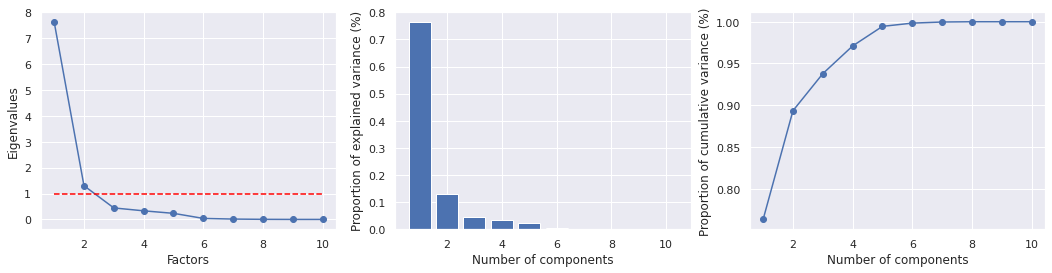

ITERATION #3
Check suitability
- Chi-square statistic is 1997.4026, with p-value 0.0
- Total KMO is 0.7284
Number of factors:  2
- Proportion of variance explained by the 2 factor(s):  [0.7881781 0.1372505]
- Proportion of cumulative variance of 2 factor(s):  0.9254285958368317


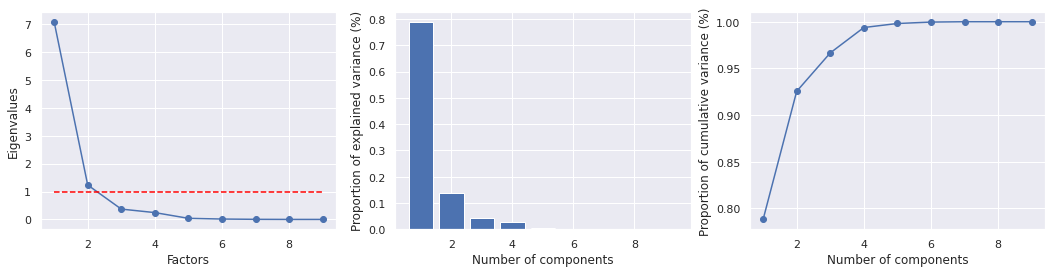

            Factor 1  Factor 2
gini        0.836155  0.185948
life_exp    0.917014  0.344599
rdpc        0.877399  0.184474
mhdi        0.947825  0.293080
mhdi_e      0.931359  0.269246
mhdi_l      0.917352  0.345173
mhdi_i      0.950045  0.284701
ETA_S_mean -0.295770 -0.945042
ETA_X_mean -0.279513 -0.950990


In [15]:
%%skip $skip_cell

fa, features, n_factors = perform_factor_analysis(df_numerical)

#### 2.1.4. Visualizing results

In [16]:
%%skip $skip_cell

# represents the data in terms of the obtained factors
cols_factors = ['Factor ' + str(i + 1) for i in range(n_factors)]
df_fa = pd.DataFrame(fa.fit_transform(df_numerical[features]), columns=cols_factors)

# select categorical columns to concat
df_categorical = df.select_dtypes(include=['object'])

# creates a dataset concating the categorical columns and the FA data
fa_data = pd.concat([df_categorical, df_fa], axis=1)
fa_data.hdu_id = fa_data.hdu_id.str[-2:]

The score plot graphs the HDU scores of the second factor versus the HDU scores of the first factor.

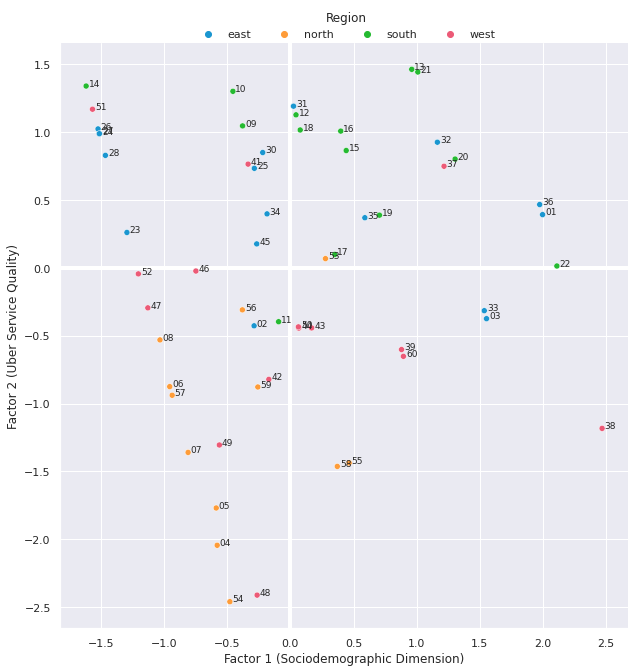

In [17]:
%%skip $skip_cell

def label_points(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']),fontsize=9)

g = sns.relplot(data=fa_data, x='Factor 1', y='Factor 2', hue='region', palette=colors, height=9, aspect=1)
g.set_axis_labels('Factor 1 (Sociodemographic Dimension)', 'Factor 2 (Uber Service Quality)')
sns.move_legend(g, 'lower center', bbox_to_anchor=(.5, 0.97), ncol=4, title='Region', frameon=False)
plt.axhline(y=0, linewidth=4, color='w', zorder=0)
plt.axvline(x=0, linewidth=4, color='w', zorder=0)
label_points(fa_data['Factor 1'], fa_data['Factor 2'], fa_data['hdu_id'], plt.gca())

### 2.2. Normalization

In [18]:
%%skip $skip_cell

scaler = MinMaxScaler()
df_norm = df_numerical[features].copy()
df_norm[:] = scaler.fit_transform(df_norm)

### 2.3. Weighting

In [19]:
%%skip $skip_cell

factor_loadings_df = pd.DataFrame(np.copy(fa.loadings_), columns=cols_factors, index=features)

# square factor loadings and scale the factors (columns) to unity sum
for i, col in enumerate(factor_loadings_df.columns):
    squared_loadings = factor_loadings_df[col] ** 2
    factor_loadings_df[col] = np.round(squared_loadings/squared_loadings.sum(), 4)

In [20]:
%%skip $skip_cell

def highlight_nlargest(s, largest):
  if s in largest.values:
    return 'background-color: #1a96d0; color: white'

# get the n lasgest factor loadings, where n is the number of features selected during
largest = factor_loadings_df.stack().nlargest(factor_loadings_df.shape[0])
display(factor_loadings_df.style.applymap(highlight_nlargest, largest=largest))

,Factor 1,Factor 2
gini,0.116800,0.014800
life_exp,0.140500,0.050700
rdpc,0.128600,0.014500
mhdi,0.150100,0.036700
mhdi_e,0.144900,0.030900
mhdi_l,0.140600,0.050800
mhdi_i,0.150800,0.034600
ETA_S_mean,0.014600,0.381100
ETA_X_mean,0.013100,0.385900


In [21]:
%%skip $skip_cell

# the intermidiate factors, which include the n largest factor loadings and zero the rest of the elements
intermediate_factors = factor_loadings_df.applymap(lambda x: 0 if x not in largest.values else x)
display(intermediate_factors)

,Factor 1,Factor 2
gini,0.1168,0.0000
life_exp,0.1405,0.0000
rdpc,0.1286,0.0000
mhdi,0.1501,0.0000
mhdi_e,0.1449,0.0000
mhdi_l,0.1406,0.0000
mhdi_i,0.1508,0.0000
ETA_S_mean,0.0000,0.3811
ETA_X_mean,0.0000,0.3859


In [22]:
%%skip $skip_cell

# the intermediate composites are aggregated by assigning a weight to each one of them equal to the proportion of the explained variance in the dataset
factors_variance = fa.get_factor_variance()[0]
variance_ratio = factors_variance/sum(factors_variance)

In [23]:
%%skip $skip_cell

weights = (variance_ratio * intermediate_factors).sum(axis=1)
weights = weights/np.sum(weights) # rescaled to sum up to one
display(pd.DataFrame(weights))

,0
gini,0.091781
life_exp,0.110404
rdpc,0.101053
mhdi,0.117948
mhdi_e,0.113862
mhdi_l,0.110483
mhdi_i,0.118498
ETA_S_mean,0.117248
ETA_X_mean,0.118725


### 2.4. Aggregation: Hybrid aggregation method (geometric + linear)

In [24]:
%%skip $skip_cell

df = pd.concat([df_categorical, df_norm], axis=1)
# geometric aggregation
df['index'] = pd.DataFrame(np.array([df_norm[col] ** weights[col]  for col in df_norm]).T).prod(axis=1)
# linear aggregation
df.loc[df['index'] == 0, 'index'] = (weights * df_norm[df['index'] == 0]).sum(axis=1)

In [25]:
%%skip $skip_cell
display(df[['hdu_id','hdu_name', 'index']].sort_values(by='index', ascending=False))

,hdu_id,hdu_name,index
36,1240810200038,Cidade da Esperança : Condomínios / Rodoviária,0.840813
21,1240810200022,Candelária / Lagoa Nova,0.711197
2,1240810200003,Areia Preta / Mãe Luiza / Petropólis,0.668769
31,1240810200033,Santos Reis / Ribeira / Rocas / Cidade Alta,0.663628
0,1240810200001,Tirol / Petropólis / Areia Preta,0.647887
12,1240810200013,Capim Macio / Ponta Negra / Neópolis / Lagoa N...,0.631469
34,1240810200036,Praia do Meio : Rua Presidente Café Filho,0.628343
20,1240810200021,Candelária : Bairro Latino,0.625073
57,1240810200060,Nordeste : Boa Vista,0.560536
37,1240810200039,Felipe Camarão : Conjunto Jardim América,0.557922


In [26]:
# reading a shape file of Natal metropolitan region and filtering just the HDUs inside the city of Natal
gdf = gpd.read_file('./data/shape/natal-hdu.shp')
gdf = gdf[gdf['NM_MUNICIP'] == 'NATAL']
gdf = gdf.rename(columns={'UDH_ATLAS': 'hdu_id'})

# conceting spatial data and the index
gdf = gdf.join(df.set_index('hdu_id'), on='hdu_id', how='inner')

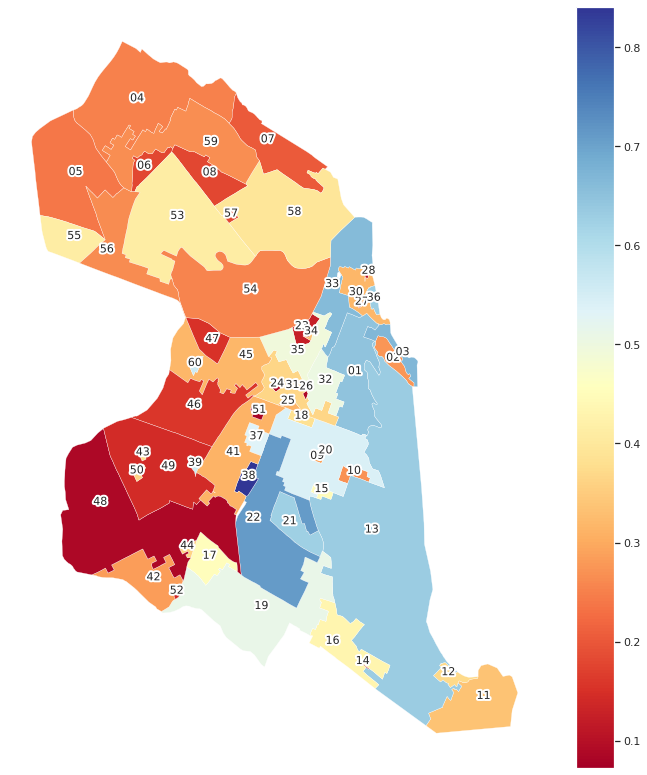

In [27]:
fig, ax = plt.subplots(1, 1,figsize=(12,14))

coords = gdf['geometry'].apply(lambda x: x.representative_point().coords[:][0])

gdf.plot(column='index', cmap='RdYlBu', linewidth=0.3, edgecolor='white', legend=True, ax=ax)
gdf.apply(lambda x: ax.annotate(text=(x.hdu_id[-2:]), xy=x.geometry.representative_point().coords[:][0], ha='center', fontsize=11, path_effects=[pe.withStroke(linewidth=4, foreground="white")]),axis=1);

ax.set_axis_off()